In [82]:
import json
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dense, Embedding, Dropout
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Preprocessing

## Data Preparation

In [3]:
data = []
with open('/kaggle/input/dm-2024-isa-5810-lab-2-homework/tweets_DM.json', 'r') as f:
    for line in f:
        data.append(json.loads(line))
f.close()

In [64]:
data = pd.DataFrame(data)
data

,_score,_index,_source,_crawldate,_type
0,391,hashtag_tweets,"{'tweet': {'hashtags': ['Snapchat'], 'tweet_id...",2015-05-23 11:42:47,tweets
1,433,hashtag_tweets,"{'tweet': {'hashtags': ['freepress', 'TrumpLeg...",2016-01-28 04:52:09,tweets
2,232,hashtag_tweets,"{'tweet': {'hashtags': ['bibleverse'], 'tweet_...",2017-12-25 04:39:20,tweets
3,376,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x1cd5...",2016-01-24 23:53:05,tweets
4,989,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2de2...",2016-01-08 17:18:59,tweets
...,...,...,...,...,...
1867530,827,hashtag_tweets,"{'tweet': {'hashtags': ['mixedfeeling', 'butim...",2015-05-12 12:51:52,tweets
1867531,368,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x29d0...",2017-10-02 17:54:04,tweets
1867532,498,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x2a6a...",2016-10-10 11:04:32,tweets
1867533,840,hashtag_tweets,"{'tweet': {'hashtags': [], 'tweet_id': '0x24fa...",2016-09-02 14:25:06,tweets


## Feature Selection

In [65]:
_source = data['_source'].apply(lambda x: x['tweet'])
df = pd.DataFrame({
    'tweet_id': _source.apply(lambda x: x['tweet_id']),
    'text': _source.apply(lambda x: x['text']),
    })
df

,tweet_id,text
0,0x376b20,"People who post ""add me on #Snapchat"" must be ..."
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #..."
2,0x28b412,"Confident of your obedience, I write to you, k..."
3,0x1cd5b0,Now ISSA is stalking Tasha 😂😂😂 <LH>
4,0x2de201,"""Trust is not the same as faith. A friend is s..."
...,...,...
1867530,0x316b80,When you buy the last 2 tickets remaining for ...
1867531,0x29d0cb,I swear all this hard work gone pay off one da...
1867532,0x2a6a4f,@Parcel2Go no card left when I wasn't in so I ...
1867533,0x24faed,"Ah, corporate life, where you can date <LH> us..."


## Data Cleaning

In [66]:
import re
import emoji

emoji_dict = {
    '😂': '[joy]',
    '❤️': '[love]',
    '😍': '[adoration]',
    '😭': '[cry]',
    '❤': '[care]',
    '😊': '[happy]',
    '🙏': '[pray]',
    '😘': '[kiss]',
    '💕': '[love_each_other]',
    '🔥': '[fire]',
    '😩': '[weary]',
    '🤔': '[think]',
    '💯': '[perfect]',
    '💙': '[loyalty]',
    '🙄': '[annoyed]',
    '😁': '[happy]',
    '🙌': '[celebrate]',
    '🙏🏾': '[pray]',
    '👍': '[approve]',
    '🙏🏽': '[pray]'
}

emoji_pattern = re.compile('|'.join(map(re.escape, emoji_dict.keys())))
lh_pattern = re.compile(r'<LH>')

def clean_tweet(text):
    text = emoji_pattern.sub(lambda m: emoji_dict[m.group()], text)
    text = lh_pattern.sub('', text)
    return text.strip()

df['text'] = df['text'].apply(clean_tweet)

## Prepare train and test datasets

In [67]:
emotion = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/emotion.csv')
data_identification = pd.read_csv('/kaggle/input/dm-2024-isa-5810-lab-2-homework/data_identification.csv')

In [68]:
df = df.merge(data_identification, on='tweet_id', how='left')

In [69]:
train_data = df[df['identification'] == 'train']
test_data = df[df['identification'] == 'test']

In [70]:
train_data = train_data.merge(emotion, on='tweet_id', how='left')

In [71]:
train_data.drop_duplicates(subset=['text'], inplace=True)

In [72]:
train_data

,tweet_id,text,identification,emotion
0,0x376b20,"People who post ""add me on #Snapchat"" must be ...",train,anticipation
1,0x2d5350,"@brianklaas As we see, Trump is dangerous to #...",train,sadness
2,0x1cd5b0,Now ISSA is stalking Tasha [joy][joy][joy],train,fear
3,0x1d755c,@RISKshow @TheKevinAllison Thx for the BEST TI...,train,joy
4,0x2c91a8,Still waiting on those supplies Liscus.,train,anticipation
...,...,...,...,...
1455558,0x321566,I'm SO HAPPY!!! #NoWonder the name of this sho...,train,joy
1455559,0x38959e,In every circumtance I'd like to be thankful t...,train,joy
1455560,0x2cbca6,there's currently two girls walking around the...,train,joy
1455561,0x24faed,"Ah, corporate life, where you can date using ...",train,joy


# Model

## Prepare Training Data

In [74]:
test_data

,tweet_id,text,identification
2,0x28b412,"Confident of your obedience, I write to you, k...",test
4,0x2de201,"""Trust is not the same as faith. A friend is s...",test
9,0x218443,When do you have enough ? When are you satisfi...,test
30,0x2939d5,"God woke you up, now chase the day #GodsPlan #...",test
33,0x26289a,"In these tough times, who do YOU turn to as yo...",test
...,...,...,...
1867525,0x2913b4,"""For this is the message that ye heard from th...",test
1867529,0x2a980e,"""There is a lad here, which hath five barley l...",test
1867530,0x316b80,When you buy the last 2 tickets remaining for ...,test
1867531,0x29d0cb,I swear all this hard work gone pay off one da...,test


In [75]:
X_train_data = train_data['text']
y_train_data = train_data['emotion']

# Prepare the test_data (only text, no emotion)
X_test_data = test_data['text']

# Split train_data into X_train and y_train, X_test, and y_test (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X_train_data, y_train_data, test_size=0.2, random_state=42, stratify=y_train_data)

print(f"Training data shape: {X_train.shape}, Test data shape: {X_test.shape}")

Training data shape: (1159852,), Test data shape: (289964,)


In [76]:
# Initialize the tokenizer and fit it on the training data
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)  # Fit tokenizer on training data

# Convert the text data into sequences (integer encoded)
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad the sequences to ensure all inputs have the same length
max_sequence_length = 100  # Maximum sequence length
X_train_padded = pad_sequences(X_train_seq, maxlen=max_sequence_length)
X_test_padded = pad_sequences(X_test_seq, maxlen=max_sequence_length)

print(f"Shape of padded X_train: {X_train_padded.shape}")
print(f"Shape of padded X_test: {X_test_padded.shape}")

Shape of padded X_train: (1159852, 100)
Shape of padded X_test: (289964, 100)


In [77]:
# Initialize LabelEncoder
label_encoder = LabelEncoder()

# Fit the label encoder on the training data
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Check the label encoding
print(f"Classes: {label_encoder.classes_}")

Classes: ['anger' 'anticipation' 'disgust' 'fear' 'joy' 'sadness' 'surprise'
 'trust']


## Training

In [78]:
# Train the Word2Vec model using the tokenized text
word2vec_model = Word2Vec(sentences=[text.split() for text in X_train], vector_size=100, window=5, min_count=1, workers=4)

# Check the vocabulary size
print(f"Vocabulary size: {len(word2vec_model.wv)}")

Vocabulary size: 1372742


In [79]:
# Prepare the embedding matrix
embedding_dim = 100  # Dimension of the word vectors
embedding_matrix = np.zeros((len(tokenizer.word_index) + 1, embedding_dim))

# Populate the embedding matrix with Word2Vec embeddings
for word, i in tokenizer.word_index.items():
    if word in word2vec_model.wv:
        embedding_matrix[i] = word2vec_model.wv[word]

print(f"Embedding matrix shape: {embedding_matrix.shape}")

Embedding matrix shape: (743451, 100)


In [83]:
# Build the CNN model
model = Sequential()
model.add(Embedding(input_dim=len(tokenizer.word_index) + 1, output_dim=embedding_dim, 
                    weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))  # Freeze embeddings
model.add(Conv1D(filters=128, kernel_size=5, activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(GlobalMaxPooling1D())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(len(label_encoder.classes_), activation='softmax'))  # Number of emotion classes

# Compile the model
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [84]:
# Train the model
model.fit(X_train_padded, y_train_encoded, batch_size=32, epochs=10, validation_split=0.2)

# Save the trained model (optional)
# model.save('emotion_model.h5')

Epoch 1/10


I0000 00:00:1733209924.942044     574 service.cc:145] XLA service 0x790e440056e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1733209924.942091     574 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1733209924.942098     574 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5


   91/28997 ━━━━━━━━━━━━━━━━━━━━ 48s 2ms/step - accuracy: 0.2455 - loss: 2.5857  

I0000 00:00:1733209928.463836     574 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


28997/28997 ━━━━━━━━━━━━━━━━━━━━ 69s 2ms/step - accuracy: 0.4059 - loss: 1.6065 - val_accuracy: 0.4719 - val_loss: 1.4445
Epoch 2/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 62s 2ms/step - accuracy: 0.4612 - loss: 1.4747 - val_accuracy: 0.4844 - val_loss: 1.4151
Epoch 3/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4766 - loss: 1.4442 - val_accuracy: 0.4955 - val_loss: 1.3966
Epoch 4/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4835 - loss: 1.4286 - val_accuracy: 0.4979 - val_loss: 1.3860
Epoch 5/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4876 - loss: 1.4183 - val_accuracy: 0.4967 - val_loss: 1.3821
Epoch 6/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4893 - loss: 1.4125 - val_accuracy: 0.4985 - val_loss: 1.3812
Epoch 7/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4916 - loss: 1.4088 - val_accuracy: 0.5029 - val_loss: 1.3738
Epoch 8/10
28997/28997 ━━━━━━━━━━━━━━━━━━━━ 63s 2ms/step - accuracy: 0.4932 - lo

## Visualization of Confusion Matrix

## Predict Testing Dataset

In [85]:
# Prepare the test data (X_test_padded) for predictions
# Predict on test data
y_pred_proba = model.predict(X_test_padded)  # Predicted probabilities
y_pred = np.argmax(y_pred_proba, axis=1)    # Predicted classes

# Decode the predictions back to labels
y_pred_labels = label_encoder.inverse_transform(y_pred)

# Show some example predictions
print(f"Example Predictions: {list(zip(X_test[:5], y_pred_labels[:5]))}")

9062/9062 ━━━━━━━━━━━━━━━━━━━━ 11s 1ms/step
Example Predictions: [('Thanking God for this day[celebrate]🏽', 'joy'), ('@CST_soxvan @WhiteSoxUK You can be the very worst, the worst there ever was.  #WorldofTanks', 'sadness'), ('Exactly 6 months form today, I will be turning 21 🤘🏻', 'joy'), ("Just remembered I have a signed pick by the @thescript and I'm", 'joy'), ('Keep the  alive: Hit the #snooze button.', 'joy')]


# Model Evaluation

9062/9062 ━━━━━━━━━━━━━━━━━━━━ 10s 1ms/step
Classification Report:
              precision    recall  f1-score   support

       anger       1.00      0.07      0.13      7941
anticipation       0.62      0.47      0.53     49707
     disgust       0.37      0.37      0.37     27794
        fear       0.69      0.24      0.36     12750
         joy       0.49      0.85      0.62    102597
     sadness       0.47      0.35      0.40     38610
    surprise       0.99      0.06      0.12      9633
       trust       0.70      0.19      0.30     40932

    accuracy                           0.51    289964
   macro avg       0.67      0.33      0.35    289964
weighted avg       0.57      0.51      0.47    289964



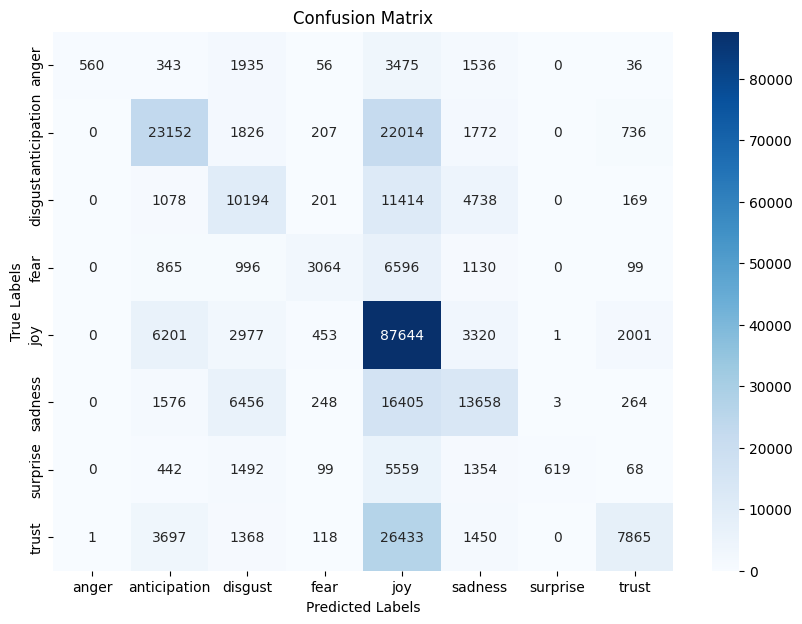

In [86]:
# Evaluate the model on validation set
y_val_pred = model.predict(X_test_padded)  # Predicted probabilities
y_val_pred_classes = np.argmax(y_val_pred, axis=1)  # Predicted classes

# Classification report on the test set
print("Classification Report:")
print(classification_report(y_test_encoded, y_val_pred_classes, target_names=label_encoder.classes_))

# Confusion Matrix
cm = confusion_matrix(y_test_encoded, y_val_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.title('Confusion Matrix')
plt.show()

# Generate Submission File

In [95]:
# Prepare the test data (only text, no emotion)
X_test_data = test_data['text']  # This is the actual test data we want to predict on

# Tokenize and pad the test data just like the training data
X_test_data_seq = tokenizer.texts_to_sequences(X_test_data)
X_test_data_padded = pad_sequences(X_test_data_seq, maxlen=max_sequence_length)

# Predict on the actual test data
y_test_data_pred = model.predict(X_test_data_padded)
y_test_data_pred_classes = np.argmax(y_test_data_pred, axis=1)  # Predicted classes

# Decode the predictions back to labels
y_test_data_pred_labels = label_encoder.inverse_transform(y_test_data_pred_classes)

12875/12875 ━━━━━━━━━━━━━━━━━━━━ 15s 1ms/step


In [106]:
# Prepare the submission DataFrame
submission = pd.DataFrame({
    'id': test_data['tweet_id'],  # Using tweet_id from test_data
    'emotion': y_test_data_pred_labels  # Predicted emotions
})

# Save the submission file
submission.to_csv('submission.csv', index=False)
print("Submission file saved.")

Submission file saved.


In [107]:
submission.head()

,id,emotion
2,0x28b412,anticipation
4,0x2de201,anticipation
9,0x218443,joy
30,0x2939d5,anticipation
33,0x26289a,trust
